<a href="https://colab.research.google.com/github/SEC-API-io/sec-api-cookbook/blob/main/notebooks/form-d/form-d-tutorial-website.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyze Form D Exempt Offerings using Python

This page provides a step-by-step guide on analyzing Form D exempt offerings using Python and the [Form D API](https://sec-api.io/docs/form-d-xml-json-api). Form D filings are submitted by companies that raise capital through private placements under Regulation D, allowing them to sell securities without full SEC registration.

**What You Will Learn**

- Use the [Form D API](https://sec-api.io/docs/form-d-xml-json-api) to retrieve structured data from offerings filed with the SEC betbween 2008 and 2024.
- Understand offering trends over time by visualizing the number of offerings per year, quarter and month.
- Find the top 20 largest offerings by amount raised
- Determine the types of securities offered
- And more...

## Quick Start

The example demonstrates how to retrieve Form D exempt offerings using the `.get_data(search_params)` method of the `FormDApi` class from the `sec-api` Python package. The script queries the database for offerings with a total offering amount of $1,000,000 or more, sorts them by the most recent filings, and returns the 10 most recent results.

In [ ]:
!pip install sec-api

In [ ]:
import json
from sec_api import FormDApi

formDApi = FormDApi("YOUR_API_KEY")

search_params = {
    "query": "offeringData.offeringSalesAmounts.totalOfferingAmount:[1000000 TO *]",
    "from": "0", # starting position of the result set
    "size": "10", # number of results to be returned. max: 50
    "sort": [{"filedAt": {"order": "desc"}}],
}

response = formDApi.get_data(search_params)
offerings = response["offerings"]

print(json.dumps(offerings[0], indent=2))

{
  "schemaVersion": "X0708",
  "submissionType": "D",
  "testOrLive": "LIVE",
  "primaryIssuer": {
    "cik": "0002057923",
    "entityName": "U.S. Venture Partners Select Fund I-A, L.P.",
    "issuerAddress": {
      "street1": "1460 EL CAMINO REAL, SUITE 100",
      "city": "MENLO PARK",
      "stateOrCountry": "CA",
      "stateOrCountryDescription": "CALIFORNIA",
      "zipCode": "94025"
    },
    "issuerPhoneNumber": "650-854-9080",
    "jurisdictionOfInc": "DELAWARE",
    "issuerPreviousNameList": [
      {
        "value": "None"
      }
    ],
    "edgarPreviousNameList": [
      {
        "value": "None"
      }
    ],
    "entityType": "Limited Partnership",
    "yearOfInc": {
      "withinFiveYears": true,
      "value": "2025"
    }
  },
  "relatedPersonsList": {
    "relatedPersonInfo": [
      {
        "relatedPersonName": {
          "firstName": "Richard",
          "middleName": "W",
          "lastName": "Lewis"
        },
        "relatedPersonAddress": {
        

## Download all Exempt Offerings from Form D

Downloading the complete Form D exempt offerings dataset may take up to 20 minutes and requires approximately 2.6GB of disk space. The final dataset includes over 600,000 records spanning from 2008 to 2024 and is saved in JSONL format as `form-d-dataset.jsonl`.

In [3]:
import os
import random
import sys
import time
from concurrent.futures import ThreadPoolExecutor

YEARS = range(2024, 2007, -1) # from 2024 to 2008
TEMP_FILE_TEMPLATE = "./temp_file_form_d_{}.jsonl"
TARGET_FILE = "./form-d-dataset.jsonl"


def process_year(year):
    backoff_time = random.randint(10, 800) / 1000
    print(f"Starting year {year} with backoff time {backoff_time:,}s")
    sys.stdout.flush()
    time.sleep(backoff_time)

    tmp_filename = TEMP_FILE_TEMPLATE.format(year)
    tmp_file = open(tmp_filename, "w")

    for month in range(12, 0, -1):
        search_from = 0
        month_counter = 0

        while True:
            query = f"filedAt:[{year}-{month:02d}-01 TO {year}-{month:02d}-31]"
            search_params = {
                "query": query,
                "from": search_from,
                "size": "50",
                "sort": [{"filedAt": {"order": "desc"}}],
            }

            response = None
            try:
                response = formDApi.get_data(search_params)
            except Exception as e:
                print(f"{year}-{month:02d} error: {e}. Retrying...")
                sys.stdout.flush()
                continue

            if response == None or len(response["offerings"]) == 0:
                break

            if response["total"]["value"] >= 10000:
                print(
                    f"WARNING: {year}-{month:02d} has more than 10,000 Form D filings."
                )
                sys.stdout.flush()

            search_from += 50
            month_counter += len(response["offerings"])
            jsonl_data = "\n".join(
                [json.dumps(entry) for entry in response["offerings"]]
            )
            tmp_file.write(jsonl_data + "\n")

        print(f"Finished loading {month_counter} Form D for {year}-{month:02d}")
        sys.stdout.flush()

    tmp_file.close()

    return year


if not os.path.exists(TARGET_FILE):
    with ThreadPoolExecutor(max_workers=4) as pool:
        processed_years = list(pool.map(process_year, YEARS))
    print("Finished processing all years.", processed_years)

    # merge the temporary files into one final file
    with open(TARGET_FILE, "a") as outfile:
        for year in YEARS:
            temp_file = TEMP_FILE_TEMPLATE.format(year)
            if os.path.exists(temp_file):
                with open(temp_file, "r") as infile:
                    outfile.write(infile.read())
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


## Loading the Form D Exempt Offerings


In [4]:
import pandas as pd
import numpy as np

In [5]:
def process_chunk(df_chunk):
    return pd.json_normalize(df_chunk.to_dict(orient="records"))


df_chunks = [
    process_chunk(chunk)
    for chunk in pd.read_json(TARGET_FILE, lines=True, chunksize=100000)
]

structured_data = pd.concat(df_chunks, ignore_index=True)

print(structured_data.shape)

(673962, 71)


In [6]:
structured_data["filedAt"] = pd.to_datetime(structured_data["filedAt"], utc=True)
structured_data["filedAt"] = structured_data["filedAt"].dt.tz_convert("US/Eastern")
structured_data = structured_data.sort_values("filedAt", ascending=True).reset_index(
    drop=True
)
structured_data["year"] = structured_data["filedAt"].dt.year
structured_data["month"] = structured_data["filedAt"].dt.month
structured_data["qtr"] = structured_data["month"].apply(lambda x: (x - 1) // 3 + 1)
structured_data["dayOfWeek"] = structured_data["filedAt"].dt.day_name()
# filedAtClass: preMarket (4:00AM-9:30AM), regularMarket (9:30AM-4:00PM), afterMarket (4:00PM-8:00PM)
structured_data["filedAtClass"] = structured_data["filedAt"].apply(
    lambda x: (
        "preMarket"
        if x.hour < 9 or (x.hour == 9 and x.minute < 30)
        else (
            "regularMarket"
            if x.hour < 16
            else "afterMarket" if x.hour < 20 else "other"
        )
    )
)

structured_data.head()

,schemaVersion,submissionType,testOrLive,accessionNo,filedAt,id,issuerList,primaryIssuer.cik,primaryIssuer.entityName,primaryIssuer.issuerAddress.street1,...,offeringData.typesOfSecuritiesOffered.isMineralPropertyType,primaryIssuer.yearOfInc.yetToBeFormed,offeringData.salesCompensationList.over100RecipientFlag,relatedPersonsList.over100PersonsFlag,issuerList.over100IssuerFlag,year,month,qtr,dayOfWeek,filedAtClass
0,X0101,D,LIVE,0001445388-08-000001,2008-09-17 10:14:41-04:00,fe0a1228846ceb5480b82521df779de7,NaN,0001445388,"Cause Global Impact Fund, LP",1266 EAST MAIN STREET,...,NaN,NaN,NaN,NaN,NaN,2008,9,3,Wednesday,regularMarket
1,X0101,D,LIVE,0001348938-08-000003,2008-09-18 17:57:02-04:00,43e701d16ff1097e33db9a31a3f7218d,NaN,0001348938,"Living Independently Group, Inc.",767 THIRD AVE,...,NaN,NaN,NaN,NaN,NaN,2008,9,3,Thursday,afterMarket
2,X0101,D,LIVE,0001445444-08-000001,2008-09-19 13:18:32-04:00,2ead4c7e5bc390b8dae552ae6b832c30,NaN,0001445444,new york atv - sportsman club llc,240 WILLOW DRIVE,...,NaN,NaN,NaN,NaN,NaN,2008,9,3,Friday,regularMarket
3,X0101,D,LIVE,0001354488-08-001636,2008-09-19 18:21:59-04:00,b3d0f624fc2992121605e7ed54fd0c17,NaN,0001445579,"Fox Life Settlements 2008-F, LLC",2129 N. JOSEY LANE,...,NaN,NaN,NaN,NaN,NaN,2008,9,3,Friday,afterMarket
4,X0101,D,LIVE,0001445773-08-000002,2008-09-22 17:15:22-04:00,fe1f4adb26cf65f5e059d2f4e6c70bdb,NaN,0001445773,Viking Financial Services Corp,4 NICKERSON STREET,...,NaN,NaN,NaN,NaN,NaN,2008,9,3,Monday,afterMarket


In [7]:
print(structured_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673962 entries, 0 to 673961
Data columns (total 76 columns):
 #   Column                                                                        Non-Null Count   Dtype                     
---  ------                                                                        --------------   -----                     
 0   schemaVersion                                                                 673962 non-null  object                    
 1   submissionType                                                                673962 non-null  object                    
 2   testOrLive                                                                    673962 non-null  object                    
 3   accessionNo                                                                   673962 non-null  object                    
 4   filedAt                                                                       673962 non-null  datetime64[ns, US/Eastern]


In [8]:
unique_years = structured_data["year"].nunique()
unique_issuers = structured_data["primaryIssuer.cik"].nunique()
unique_filings = structured_data["accessionNo"].nunique()
min_year = structured_data["year"].min()
max_year = structured_data["year"].max()
max_year_full = max_year  # to avoid incomplete data for the current year
print("Loaded Form D filings")
print(f"Number of filings: {unique_filings:,}")
print(f"Number of years: {unique_years:,} ({min_year}-{max_year})")
print(f"Number of unique issuers: {unique_issuers:,}")

Loaded Form D filings
Number of filings: 673,962
Number of years: 17 (2008-2024)
Number of unique issuers: 312,008


## Exempt Offerings Over Time


In [9]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
import seaborn as sns

style.use("default")

params = {
    "axes.labelsize": 8, "font.size": 8, "legend.fontsize": 8,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "font.family": "sans-serif",
    "axes.spines.top": False, "axes.spines.right": False, "grid.color": "grey",
    "axes.grid": True, "axes.grid.axis": "y", "grid.alpha": 0.5, "grid.linestyle": ":",
}

plt.rcParams.update(params)

In [10]:
submissionTypeCount = structured_data["submissionType"].value_counts().to_frame()
submissionTypeCount.columns = ["count"]
submissionTypeCount["pct"] = (
    submissionTypeCount["count"] / submissionTypeCount["count"].sum() * 100
)
submissionTypeCount["pct"] = submissionTypeCount["pct"].round(1)
submissionTypeCount

,count,pct
submissionType,,
D,412513,61.2
D/A,261449,38.8


### Offerings by Year

In [11]:
form_d = structured_data[structured_data["submissionType"] == "D"]
form_d_a = structured_data[structured_data["submissionType"] == "D/A"]

counts_d = form_d.groupby(["year"]).size().to_frame(name="count")
counts_d_a = form_d_a.groupby(["year"]).size().to_frame(name="count")

print(f"Form D counts from {min_year} to {max_year_full}.")
counts_d.T

Form D counts from 2008 to 2024.


year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
count,379,13770,17586,18170,18190,19841,22194,23030,23097,24589,27272,27502,28147,42506,41671,31868,32701


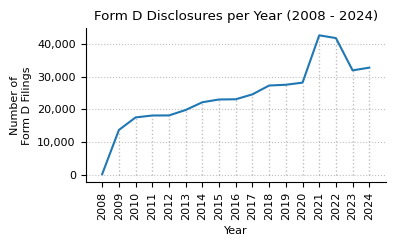

In [12]:
def plot_timeseries(ts, title):
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ts["count"].plot(ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of\nForm D Filings")
    ax.set_xticks(np.arange(min_year, max_year_full + 1, 1))
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.set_xlim(min_year - 1, max_year_full + 1)
    ax.grid(axis="x")
    ax.set_axisbelow(True)
    plt.xticks(rotation=90)

    for year in range(min_year, max_year_full + 1, 1):
        year_y_max = ts.loc[year, "count"]
        ax.vlines(year, 0, year_y_max, linestyles=":", colors="grey", alpha=0.5, lw=1)

    plt.tight_layout()
    plt.show()


plot_timeseries(
    counts_d,
    title=f"Form D Disclosures per Year ({min_year} - {max_year_full})",
)

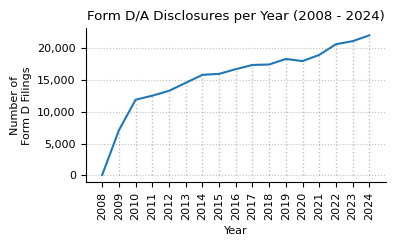

In [13]:
plot_timeseries(
    counts_d_a,
    title=f"Form D/A Disclosures per Year ({min_year} - {max_year_full})",
)

### Offerings by Quarter

In [14]:
counts_qtr_yr_piv = (form_d.groupby(["year", "qtr"]).size().unstack().fillna(0)).astype(
    int
)

print(f"Form D counts by quarter from {min_year} to {max_year_full}.")
counts_qtr_yr_piv.T

Form D counts by quarter from 2008 to 2024.


year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
qtr,,,,,,,,,,,,,,,,,
1,0,1547,4649,4848,4970,5031,5546,5786,6107,6405,6992,6761,7218,9303,12465,8320,7924
2,0,3886,4403,4460,4572,4568,5504,5780,5757,6047,6803,7025,5958,10513,10764,8095,8248
3,36,4126,4104,4506,4238,4942,5435,5679,5448,5834,6587,6889,6776,10498,9558,7735,8027
4,343,4211,4430,4356,4410,5300,5709,5785,5785,6303,6890,6827,8195,12192,8884,7718,8502


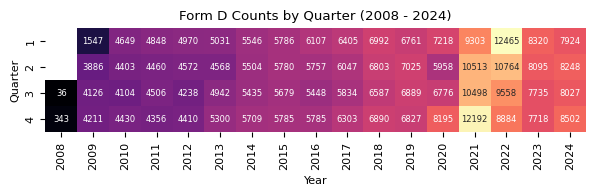

In [15]:
plt.figure(figsize=(6, 2))
sns.heatmap(
    counts_qtr_yr_piv.T,
    annot=True,
    fmt="d",
    cmap="magma",
    cbar_kws={"label": "Count"},
    mask=counts_qtr_yr_piv.T == 0,
    cbar=False,
    annot_kws={"fontsize": 6},
)
plt.grid(False)
plt.title(f"Form D Counts by Quarter ({min_year} - {max_year_full})")
plt.xlabel("Year")
plt.ylabel("Quarter")
plt.tight_layout()
plt.show()

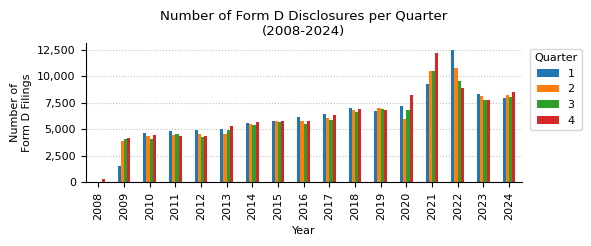

In [16]:
counts_qtr_yr = counts_qtr_yr_piv.stack().reset_index(name="count")

fig, ax = plt.subplots(figsize=(6, 2.5))
counts_qtr_yr_piv.plot(kind="bar", ax=ax, legend=True)
ax.legend(title="Quarter", loc="upper right", bbox_to_anchor=(1.15, 1))
ax.set_title(f"Number of Form D Disclosures per Quarter\n({min_year}-{max_year_full})")
ax.set_xlabel("Year")
ax.set_ylabel("Number of\nForm D Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

### Offerings by Month

In [17]:
counts_month_yr_piv = (
    form_d.groupby(["year", "month"]).size().unstack().fillna(0)
).astype(int)

print(
    f"Descriptive statistics for Form D counts by month from 2009 to {max_year_full}."
)
month_stats = (
    counts_month_yr_piv.loc[2009:]
    .describe(percentiles=[0.025, 0.975])
    .round(0)
    .astype(int)
)
month_stats

Descriptive statistics for Form D counts by month from 2009 to 2024.


month,1,2,3,4,5,6,7,8,9,10,11,12
count,16,16,16,16,16,16,16,16,16,16,16,16
mean,2264,1873,2355,2180,2100,2119,2189,2129,1956,2207,2005,2381
std,839,754,857,766,702,647,649,669,611,706,632,814
min,174,218,1155,1346,1231,1309,1459,1289,1246,1384,1298,1481
2.5%,723,617,1349,1380,1266,1370,1466,1327,1249,1388,1322,1499
50%,2170,1846,2220,1946,1878,2049,2036,2003,1812,2030,1950,2207
97.5%,3676,3347,4274,3822,3495,3480,3486,3444,3216,3590,3356,4052
max,4106,3666,4693,3977,3624,3670,3562,3482,3454,3973,3685,4534


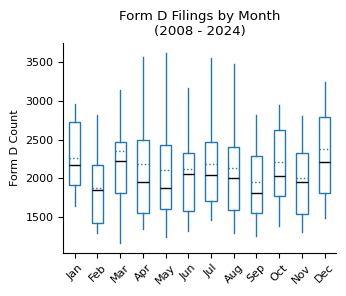

In [18]:
fig, ax = plt.subplots(figsize=(3.5, 3))

counts_month_yr_piv.loc[2009:].boxplot(
    ax=ax,
    grid=False,
    showfliers=False,
    flierprops=dict(marker="o", markersize=3),
    patch_artist=True,
    boxprops=dict(facecolor="white", color="tab:blue"),
    showmeans=True,
    meanline=True,
    meanprops={"color": "tab:blue", "linestyle": ":"},
    medianprops={"color": "black"},
    capprops={"color": "none"},
)

ax.set_title(f"Form D Filings by Month\n({min_year} - {max_year_full})")
ax.set_xlabel("")
ax.set_ylabel("Form D Count")
xticklabels = [pd.to_datetime(str(x), format="%m").strftime("%b") for x in range(1, 13)]
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
counts_month_yr_piv_d_a = (
    form_d_a.groupby(["year", "month"]).size().unstack().fillna(0)
).astype(int)

print(
    f"Descriptive statistics for Form D/A counts by month from 2009 to {max_year_full}."
)
month_stats = (
    counts_month_yr_piv_d_a.loc[2009:]
    .describe(percentiles=[0.025, 0.975])
    .round(0)
    .astype(int)
)
month_stats

Descriptive statistics for Form D/A counts by month from 2009 to 2024.


month,1,2,3,4,5,6,7,8,9,10,11,12
count,16,16,16,16,16,16,16,16,16,16,16,16
mean,1495,1453,2580,1404,1208,1200,1290,1113,1101,1264,1034,1194
std,542,404,533,423,399,411,392,366,328,354,306,401
min,44,172,2028,510,449,413,642,487,492,546,467,495
2.5%,284,563,2057,627,502,498,681,544,533,604,527,546
50%,1680,1502,2409,1424,1234,1298,1338,1161,1183,1280,1060,1212
97.5%,2065,1923,3750,2041,1836,1797,1835,1771,1556,1749,1449,1788
max,2088,1988,3942,2086,1884,1830,1899,1836,1580,1842,1484,1866


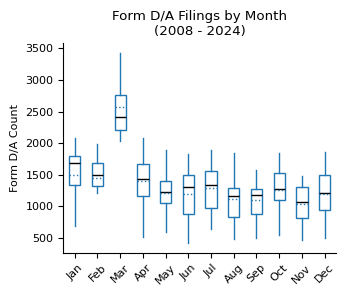

In [20]:
fig, ax = plt.subplots(figsize=(3.5, 3))

counts_month_yr_piv_d_a.loc[2009:].boxplot(
    ax=ax,
    grid=False,
    showfliers=False,
    flierprops=dict(marker="o", markersize=3),
    patch_artist=True,
    boxprops=dict(facecolor="white", color="tab:blue"),
    showmeans=True,
    meanline=True,
    meanprops={"color": "tab:blue", "linestyle": ":"},
    medianprops={"color": "black"},
    capprops={"color": "none"},
)

ax.set_title(f"Form D/A Filings by Month\n({min_year} - {max_year_full})")
ax.set_xlabel("")
ax.set_ylabel("Form D/A Count")
xticklabels = [pd.to_datetime(str(x), format="%m").strftime("%b") for x in range(1, 13)]
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Top 20 Largest Offerings by Amount Offered

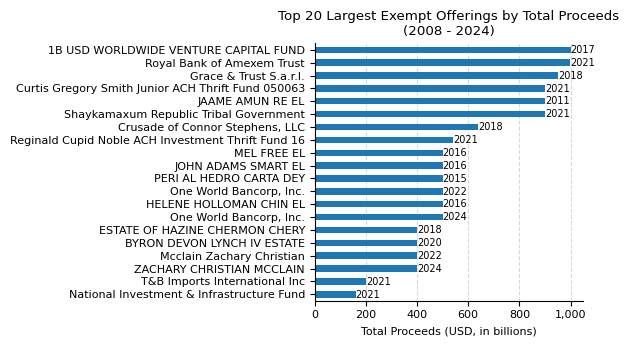

In [21]:
pd.options.display.float_format = "{:,.0f}".format

col = "offeringData.offeringSalesAmounts.totalOfferingAmount"

top_20 = (
    form_d.sort_values(by=col, ascending=False)
    .head(20)
    .sort_values(by=col, ascending=True)
    .reset_index(drop=True)
)
top_20["year"] = top_20["filedAt"].dt.year
# cut names to 50 characters
top_20["primaryIssuer.entityName"] = top_20["primaryIssuer.entityName"].str.slice(0, 50)

years = top_20["filedAt"].dt.year.to_list()

top_20.plot(
    kind="barh",
    x="primaryIssuer.entityName",
    y=col,
    figsize=(6, 3.5),
)

ax = plt.gca()
for p, year in zip(ax.patches, years):
    ax.annotate(
        year,
        (p.get_x() + p.get_width(), p.get_y()),
        xytext=(0, 0),
        textcoords="offset points",
        fontsize=7,
    )

ax.xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, p: format(int(x) / 1000000000, ",.0f"))
)
ax.grid(True)
ax.set_axisbelow(True)
ax.grid(color="gray", linestyle="dashed", alpha=0.3)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.grid(False), ax.legend().remove()
plt.title(f"Top 20 Largest Exempt Offerings by Total Proceeds\n({min_year} - {max_year})")
plt.xlabel("Total Proceeds (USD, in billions)")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [22]:
print(f"Top 20 Largest Offerings by Total Offering Amounts (in $ billions, {min_year} - {max_year})")
top_20["offeringAmount"] = top_20[col] / 1_000_000_000
top_20[["primaryIssuer.entityName", "offeringAmount", "year"]].sort_values(
    by="offeringAmount", ascending=False
).reset_index(drop=True)

Top 20 Largest Offerings by Total Offering Amounts (in $ billions, 2008 - 2024)


,primaryIssuer.entityName,offeringAmount,year
0,1B USD WORLDWIDE VENTURE CAPITAL FUND,"1,000",2017
1,Royal Bank of Amexem Trust,999,2021
2,Grace & Trust S.a.r.l.,950,2018
3,Curtis Gregory Smith Junior ACH Thrift Fund 05...,900,2021
4,JAAME AMUN RE EL,900,2011
5,Shaykamaxum Republic Tribal Government,900,2021
6,"Crusade of Connor Stephens, LLC",640,2018
7,Reginald Cupid Noble ACH Investment Thrift Fun...,541,2021
8,MEL FREE EL,500,2016
9,JOHN ADAMS SMART EL,500,2016


### Aggregated Annual Offering Amounts by Year

In [23]:
total = form_d[["year", col]].copy()
total.fillna(0, inplace=True)
total = total.apply(pd.to_numeric, errors="coerce").fillna(0)
total

,year,offeringData.offeringSalesAmounts.totalOfferingAmount
0,2008,300000000
1,2008,11498347
2,2008,500000
3,2008,3300000
4,2008,10000000
...,...,...
673956,2024,26000
673958,2024,-1
673959,2024,2500000
673960,2024,2000000


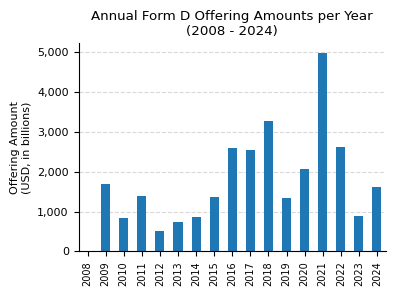

In [24]:
total_by_year = total.groupby("year").sum()
total_by_year.plot(kind="bar", figsize=(4, 3))
plt.title(f"Annual Form D Offering Amounts per Year\n({min_year} - {max_year})")
plt.ylabel("Offering Amount\n(USD, in billions)"); plt.xlabel("")
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x) / 1000000000, ",.0f")))
ax.get_legend().remove(), ax.grid(), ax.set_axisbelow(True)
ax.grid(True); ax.set_axisbelow(True); ax.grid(color="gray", linestyle="dashed", alpha=0.3)
ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False); ax.xaxis.grid(False)
plt.setp(ax.get_xticklabels(), fontsize=7); plt.tight_layout(); plt.show()

## Types of Securities Offered

In [25]:
typesOfSecuritiesOfferedCols = [col for col in form_d.columns if "typesOfSecuritiesOffered" in col]
typesOfSecuritiesOfferedCols.remove("offeringData.typesOfSecuritiesOffered.descriptionOfOtherType")
typesOfSecuritiesOffered = form_d[["year", *typesOfSecuritiesOfferedCols]]
typesOfSecuritiesOffered = typesOfSecuritiesOffered.groupby("year").count()
typesOfSecuritiesOffered.columns = [col.split(".")[-1] for col in typesOfSecuritiesOffered.columns]

print("Types of Securities Offered by Year")
typesOfSecuritiesOffered

Types of Securities Offered by Year


,isDebtType,isOptionToAcquireType,isOtherType,isEquityType,isSecurityToBeAcquiredType,isPooledInvestmentFundType,isTenantInCommonType,isMineralPropertyType
year,,,,,,,,
2008,51,50,46,239,25,64,3,3
2009,1848,1936,1798,8632,1092,3174,33,119
2010,2226,2510,2167,11616,1527,4034,22,152
2011,2299,2349,2298,12211,1522,4227,51,149
2012,2377,2217,2267,12076,1530,4461,31,146
2013,2671,2160,2203,12890,1522,5272,27,134
2014,3021,2314,2314,14555,1667,5924,28,175
2015,3126,2258,2454,14796,1586,6653,44,82
2016,2972,2260,2240,14966,1689,6867,58,36


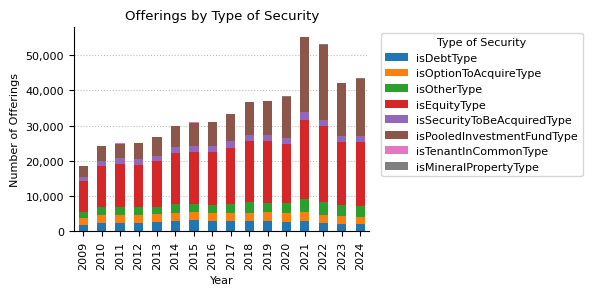

In [26]:
fig, ax = plt.subplots(figsize=(6, 3))

typesOfSecuritiesOffered.loc[2009:].plot(kind="bar", stacked=True, ax=ax)

ax.set_title("Offerings by Type of Security")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Offerings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
ax.legend(title="Type of Security", bbox_to_anchor=(1.02, 1))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Industry Groups

In [72]:
industryGroupType = form_d["offeringData.industryGroup.industryGroupType"].value_counts().to_frame()
industryGroupType.index.name = "industryGroupType"
industryGroupType["count"] = industryGroupType["count"].apply(lambda x: f"{x:,}")
industryGroupType

,count
industryGroupType,
Pooled Investment Fund,"149,718"
Other,"57,952"
Other Technology,"56,359"
Commercial,"19,627"
Other Health Care,"15,923"
Other Real Estate,"14,889"
Residential,"12,196"
Biotechnology,"11,133"
REITS and Finance,"8,839"


### Offerings per Industry Group over Time

In [109]:
topIndustryGroupTypes = industryGroupType.head(10).index.to_list()
topIndustryGroupTypes.remove("Other")

# create piv table for industry group type, year, and count
form_d_top_10_others = form_d.copy()
form_d_top_10_others.loc[
    ~form_d_top_10_others["offeringData.industryGroup.industryGroupType"].isin(
        topIndustryGroupTypes
    ),
    "offeringData.industryGroup.industryGroupType",
] = "Other"
industryGroupTypePiv = (
    form_d_top_10_others.groupby(
        ["offeringData.industryGroup.industryGroupType", "year"]
    )
    .size()
    .unstack()
    .fillna(0)
)
industryGroupTypePiv.index.name = "industryGroupType"
industryGroupTypePiv["total"] = industryGroupTypePiv.sum(axis=1)
industryGroupTypePiv = industryGroupTypePiv.reindex(
    index=topIndustryGroupTypes + ["Other"]
)

print("Offerings by Top 10 Industry Groups per Year")
industryGroupTypePiv.apply(lambda x: x.apply(lambda y: f"{y:,}"), axis=1)

Offerings by Top 10 Industry Groups per Year


year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,total
industryGroupType,,,,,,,,,,,,,,,,,,
Pooled Investment Fund,68,"3,407","4,182","4,304","4,455","5,232","5,844","6,453","6,621","7,487","9,102","9,413","11,355","20,930","20,673","14,500","15,692","149,718"
Other Technology,57,"1,999","2,579","2,925","2,992","3,210","3,682","3,876","3,778","3,749","4,140","3,879","3,618","4,741","4,260","3,588","3,286","56,359"
Commercial,14,279,429,498,563,694,796,"1,038","1,201","1,378","1,489","1,737","1,511","2,128","2,386","1,660","1,826","19,627"
Other Health Care,23,696,912,920,916,926,"1,020","1,068","1,089","1,106","1,095","1,139","1,030","1,185",956,"1,011",831,"15,923"
Other Real Estate,16,317,390,483,547,614,811,874,842,984,"1,094","1,282","1,095","1,415","1,521","1,193","1,411","14,889"
Residential,10,191,254,284,398,517,593,749,838,830,837,983,868,"1,393","1,463","1,074",914,"12,196"
Biotechnology,11,536,687,638,622,606,661,713,706,746,750,726,783,823,734,729,662,"11,133"
REITS and Finance,3,93,161,211,346,403,545,508,620,767,693,631,725,718,988,774,653,"8,839"
Investing,11,367,476,491,394,421,482,460,458,469,507,512,572,794,673,507,689,"8,283"


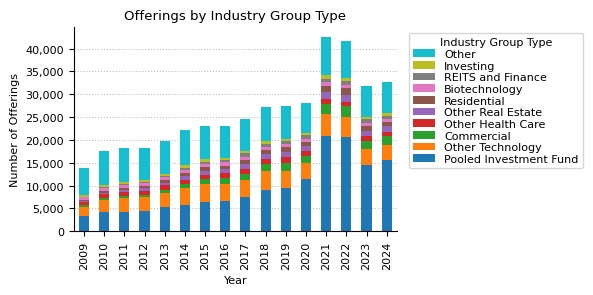

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))

industryGroupTypePiv.T.loc[2009:2024, :].plot(kind="bar", stacked=True, ax=ax)

ax.set_title("Offerings by Industry Group Type")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Offerings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles),
    reversed(labels),
    title="Industry Group Type",
    bbox_to_anchor=(1.02, 1),
    labelspacing=0.15,
)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Types of Pooled Investment Funds

In [91]:
form_d_pooledInvestmentFunds = form_d[
    form_d["offeringData.industryGroup.industryGroupType"] == "Pooled Investment Fund"
]
pooledFundTypes = (
    form_d_pooledInvestmentFunds[
        "offeringData.industryGroup.investmentFundInfo.investmentFundType"
    ]
    .value_counts()
    .to_frame()
)
pooledFundTypes["count"] = pooledFundTypes["count"].apply(lambda x: f"{x:,}")
pooledFundTypes.index.name = "Pooled Investment Fund Type"

print("Offerings per Type of Pooled Investment Fund (2008 - 2024)")
pooledFundTypes

Offerings per Type of Pooled Investment Fund (2008 - 2024)


,count
Pooled Investment Fund Type,
Venture Capital Fund,"42,098"
Other Investment Fund,"39,549"
Private Equity Fund,"39,214"
Hedge Fund,"28,857"


In [ ]:
pooledFundTypesPiv = (
    form_d_pooledInvestmentFunds.groupby(
        ["offeringData.industryGroup.investmentFundInfo.investmentFundType", "year"]
    )
    .size()
    .unstack()
    .fillna(0)
)
pooledFundTypesPiv.index.name = "Pooled Investment Fund Type"
pooledFundTypesPiv["total"] = pooledFundTypesPiv.sum(axis=1)
pooledFundTypesPiv = pooledFundTypesPiv.sort_values(by="total", ascending=False)

print("Offerings by Pooled Investment Fund Type per Year")
pooledFundTypesPiv.apply(lambda x: x.apply(lambda y: f"{y:,}"), axis=1)

Offerings by Pooled Investment Fund Type per Year


year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,total
Pooled Investment Fund Type,,,,,,,,,,,,,,,,,,
Venture Capital Fund,5,131,232,328,365,474,682,936,896,925,"1,266","2,252","3,300","8,631","9,295","6,003","6,377","42,098"
Other Investment Fund,14,803,968,974,"1,055","1,257","1,648","1,987","2,088","2,541","3,172","2,722","3,261","5,458","5,001","3,197","3,403","39,549"
Private Equity Fund,7,527,840,"1,034","1,083","1,390","1,582","1,706","1,936","2,256","2,794","2,948","3,194","4,827","4,736","3,922","4,432","39,214"
Hedge Fund,42,"1,946","2,142","1,968","1,952","2,111","1,932","1,824","1,701","1,765","1,870","1,491","1,600","2,014","1,641","1,378","1,480","28,857"


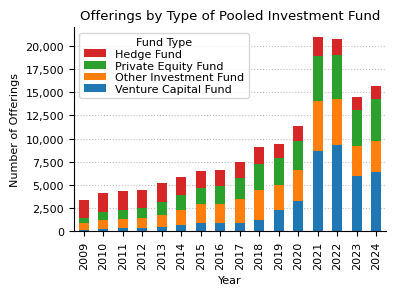

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))

pooledFundTypesPiv.T.loc[2009:2024, :].plot(kind="bar", stacked=True, ax=ax)

ax.set_title("Offerings by Type of Pooled Investment Fund")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Offerings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles),
    reversed(labels),
    title="Fund Type",
    labelspacing=0.15,
)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Issuer Size: Revenue Range and Net Asset Values

In [28]:
revenueRange = form_d["offeringData.issuerSize.revenueRange"].value_counts().to_frame()
revenueRange["count"] = revenueRange["count"].apply(lambda x: f"{x:,}")
revenueRange.index.name = "Revenue Range"
print("Issuer Size by Revenue Range")
revenueRange

Issuer Size by Revenue Range


,count
Revenue Range,
Decline to Disclose,"254,194"
No Revenues,"39,942"
"$1 - $1,000,000","21,831"
Not Applicable,"9,899"
"$1,000,001 - $5,000,000","8,643"
"$5,000,001 - $25,000,000","5,307"
"$25,000,001 - $100,000,000","2,228"
"Over $100,000,000","2,063"


In [29]:
netAssetRange = form_d["offeringData.issuerSize.aggregateNetAssetValueRange"].value_counts().to_frame()
netAssetRange["count"] = netAssetRange["count"].apply(lambda x: f"{x:,}")
netAssetRange.index.name = "Net Asset Range"
print("Issuer Size by Net Asset Range")
netAssetRange

Issuer Size by Net Asset Range


,count
Net Asset Range,
Decline to Disclose,"60,605"
"$1 - $5,000,000","2,294"
"$5,000,001 - $25,000,000","1,397"
No Aggregate Net Asset Value,"1,281"
Not Applicable,"1,120"
"Over $100,000,000",773
"$25,000,001 - $50,000,000",501
"$50,000,001 - $100,000,000",435
